In [1]:
from skimage import filters, img_as_float
from skimage.exposure import rescale_intensity
from skimage.morphology import disk

from scipy import fftpack

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
import pandas as pd

import pims
import trackpy as tp

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

from skimage.feature import blob_dog, blob_log, blob_doh

from math import sqrt

%matplotlib inline

Here are 3 example movies. The bright_stack is SpH-KOR, dim_stack is SpH-B2, and tfr_stack is one of the nicest TfR cells from the previous dataset.

In [2]:
bright_stack = pims.TiffStack('test_stack.tif')
dim_stack = pims.TiffStack('dim_stack.tif')
tfr_stack = pims.TiffStack('tfr_stack.tif')

These have different overall intensitities. Here they are, all scaled with the same intensity:

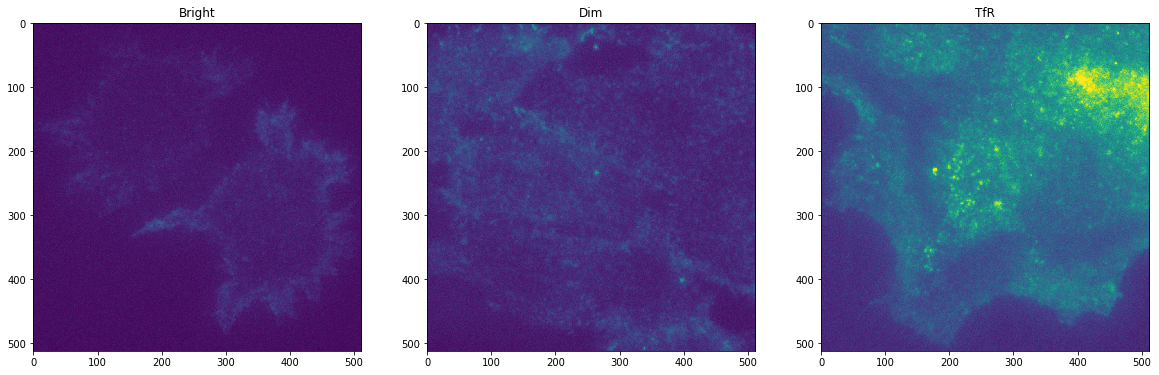

In [9]:
fig, axs = plt.subplots(1,3, figsize=(20,10))
vmin = np.min([np.min(dim_stack[48]), np.min(bright_stack[379]), np.min(tfr_stack[134])])
vmax = np.max([np.max(dim_stack[48]), np.max(bright_stack[379]), np.max(tfr_stack[134])])
axs[0].imshow(bright_stack[379], vmin=vmin, vmax=vmax)
axs[0].set_title('Bright')
axs[1].imshow(dim_stack[48], vmin=vmin, vmax=vmax)
axs[1].set_title('Dim')
axs[2].imshow(tfr_stack[134], vmin=vmin, vmax=vmax)
axs[2].set_title('TfR')
plt.show()

They also have different levels of noise. Here they are autoscaled - you can see that Bright has low noise (mostly just fuzzy background), TfR has a lot of bright spots that might be interpreted as puffs, and Dim has a lot of extraneous signal that looks like it might be confused for real puffs. To emphasize these differences, here are the same frames, but with min/max scaling set independently for each frame:

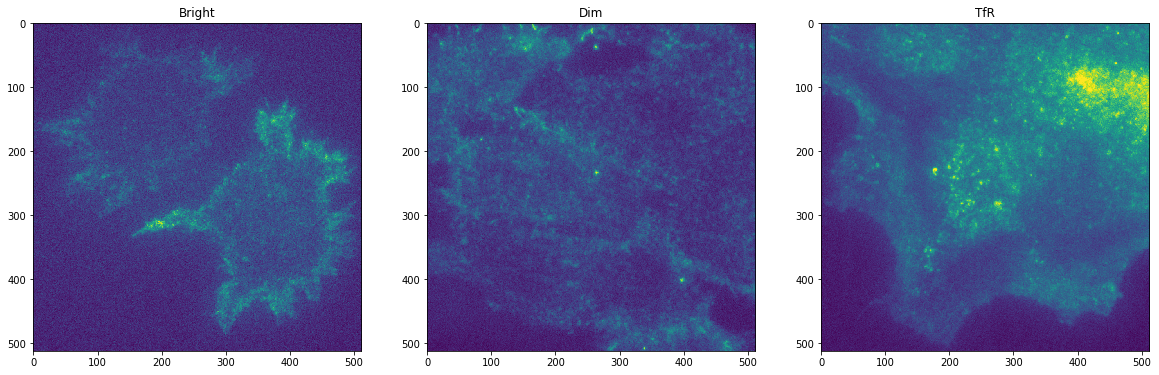

In [10]:
fig, axs = plt.subplots(1,3, figsize=(20,10))
axs[0].imshow(bright_stack[379])
axs[0].set_title('Bright')
axs[1].imshow(dim_stack[48])
axs[1].set_title('Dim')
axs[2].imshow(tfr_stack[134])
axs[2].set_title('TfR')
plt.show()

Finally, these frames were picked because I wanted to make sure we were capturing puffs in the detection below. Here I've highlighted at least a couple of the puffs in each frame. Note that these are not exhaustive for each frame (esp. the TfR frame) but they are meant to give an idea that the puffs are high signal compared to the rest of the frame.

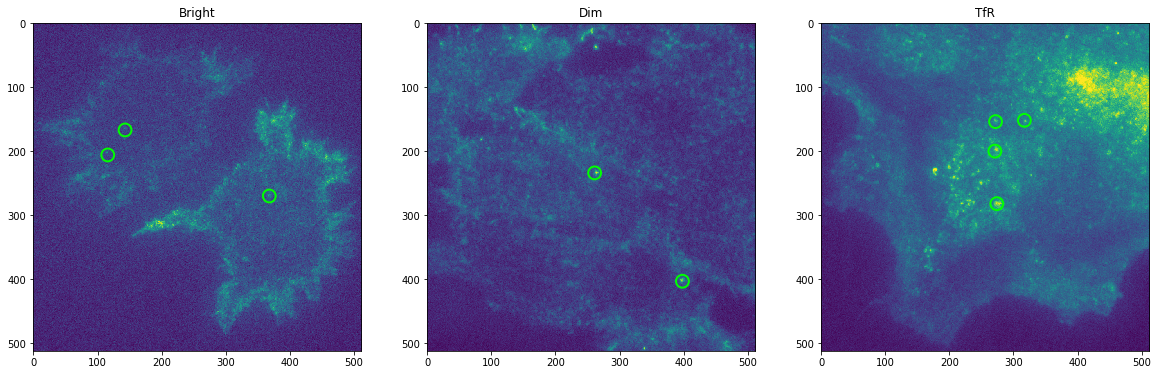

In [16]:
fig, axs = plt.subplots(1,3, figsize=(20,10))
axs[0].imshow(bright_stack[379])
axs[0].set_title('Bright')
c = plt.Circle((368, 270), 10, color='lime', linewidth=2, fill=False)
axs[0].add_patch(c)
c = plt.Circle((143, 167), 10, color='lime', linewidth=2, fill=False)
axs[0].add_patch(c)
c = plt.Circle((116, 206), 10, color='lime', linewidth=2, fill=False)
axs[0].add_patch(c)
axs[1].imshow(dim_stack[48])
axs[1].set_title('Dim')
c = plt.Circle((261, 234), 10, color='lime', linewidth=2, fill=False)
axs[1].add_patch(c)
c = plt.Circle((398, 403), 10, color='lime', linewidth=2, fill=False)
axs[1].add_patch(c)
axs[2].imshow(tfr_stack[134])
axs[2].set_title('TfR')
c = plt.Circle((274, 282), 10, color='lime', linewidth=2, fill=False)
axs[2].add_patch(c)
c = plt.Circle((317, 152), 10, color='lime', linewidth=2, fill=False)
axs[2].add_patch(c)
c = plt.Circle((272, 154), 10, color='lime', linewidth=2, fill=False)
axs[2].add_patch(c)
c = plt.Circle((271, 200), 10, color='lime', linewidth=2, fill=False)
axs[2].add_patch(c)
plt.show()

Ideally, we'd like to conduct the blob detection on images with minimal noise. I tried the denoising options available in skimage (TV, bilateral, and wavelet-based):

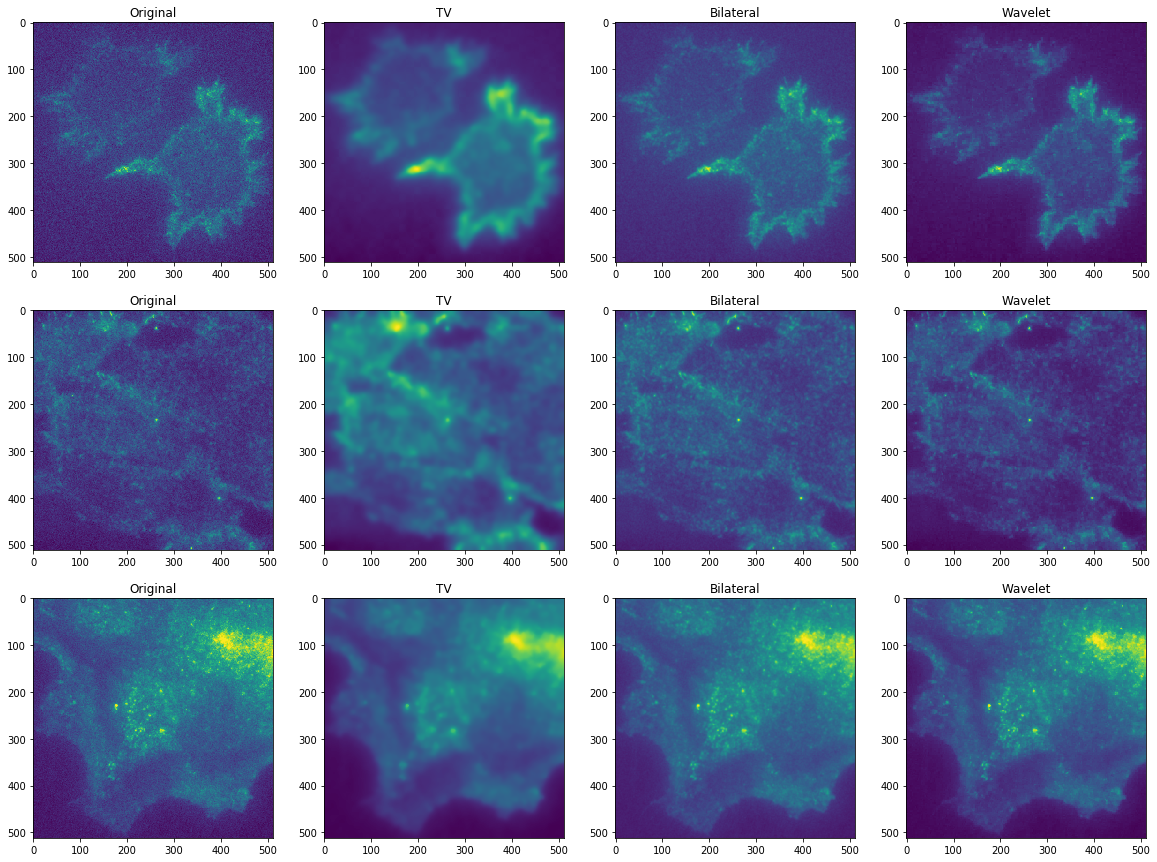

In [22]:
fig, axs = plt.subplots(3,4, figsize=(20,15))
axs = axs.ravel()

img = bright_stack[379]
axs[0].imshow(img)
axs[0].set_title('Original')
denoised_tv = denoise_tv_chambolle(img, multichannel=False)
denoised_bilateral = denoise_bilateral(img, multichannel=False)
denoised_wavelet = denoise_wavelet(img, multichannel=False)
axs[1].imshow(denoised_tv)
axs[1].set_title('TV')
axs[2].imshow(denoised_bilateral)
axs[2].set_title('Bilateral')
axs[3].imshow(denoised_wavelet)
axs[3].set_title('Wavelet')

img = dim_stack[48]
axs[4].imshow(img)
axs[4].set_title('Original')
denoised_tv = denoise_tv_chambolle(img, multichannel=False)
denoised_bilateral = denoise_bilateral(img, multichannel=False)
denoised_wavelet = denoise_wavelet(img, multichannel=False)
axs[5].imshow(denoised_tv)
axs[5].set_title('TV')
axs[6].imshow(denoised_bilateral)
axs[6].set_title('Bilateral')
axs[7].imshow(denoised_wavelet)
axs[7].set_title('Wavelet')

img = tfr_stack[134]
axs[8].imshow(img)
axs[8].set_title('Original')
denoised_tv = denoise_tv_chambolle(img, multichannel=False)
denoised_bilateral = denoise_bilateral(img, multichannel=False)
denoised_wavelet = denoise_wavelet(img, multichannel=False)
axs[9].imshow(denoised_tv)
axs[9].set_title('TV')
axs[10].imshow(denoised_bilateral)
axs[10].set_title('Bilateral')
axs[11].imshow(denoised_wavelet)
axs[11].set_title('Wavelet')
plt.show()

Looks like Wavelet denoising is most robust across intensities. Subsequently, I try the similar blob-detection available in skimage, and this is where my realization came from - you can see below that I use blob_log with the same fixed params across all 3 movies, and the results are pretty variable across the board.

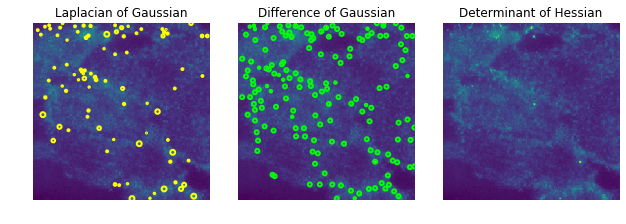

In [22]:
img = dim_stack[48]
denoised_wavelet = denoise_wavelet(img, multichannel=False)
blobs_log = blob_log(denoised_wavelet, max_sigma=5, min_sigma = 1, num_sigma=10, threshold=.01)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(denoised_wavelet, max_sigma=5, min_sigma = 1, threshold=0.01)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(denoised_wavelet, max_sigma=5, min_sigma = 1, num_sigma=10, threshold=0.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(denoised_wavelet, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

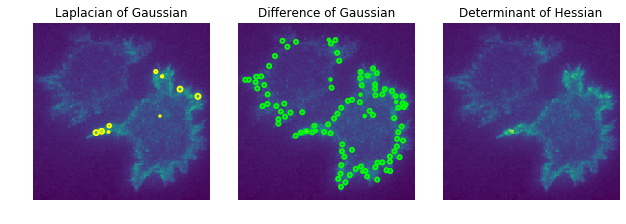

In [19]:
img = bright_stack[379]
denoised_wavelet = denoise_wavelet(img, multichannel=False)
blobs_log = blob_log(denoised_wavelet, max_sigma=5, min_sigma = 1, num_sigma=10, threshold=.01)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(denoised_wavelet, max_sigma=5, min_sigma = 1, threshold=0.005)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(denoised_wavelet, max_sigma=5, min_sigma = 1, num_sigma=10, threshold=0.005)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(denoised_wavelet, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

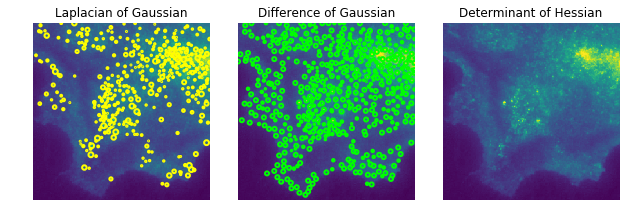

In [23]:
img = tfr_stack[134]
denoised_wavelet = denoise_wavelet(img, multichannel=False)

blobs_log = blob_log(denoised_wavelet, max_sigma=5, min_sigma = 1, num_sigma=10, threshold=.01)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(denoised_wavelet, max_sigma=5, min_sigma = 1, threshold=0.005)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(denoised_wavelet, max_sigma=5, min_sigma = 1, num_sigma=10, threshold=0.005)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(denoised_wavelet, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

Aaaand you can safely ignore everything down here for now. Nothing to see here, move along :)

In [221]:
@pims.pipeline
def highpass_filter(frame, sigma=2):
    blurred_frame = filters.gaussian(frame, sigma, preserve_range=True)
    filtered_frame = frame - blurred_frame
    filtered_frame[filtered_frame<0] = 0
    
    return filtered_frame

In [236]:
mean_im = np.mean(bright_stack,axis=0)
subtracted = np.subtract(bright_stack, mean_im)
subtracted[subtracted<0] = 0
subtracted_filtered = highpass_filter(subtracted)

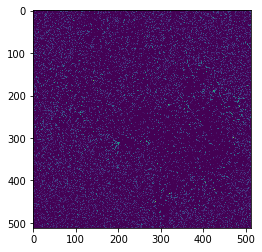

In [237]:
plt.imshow(subtracted_filtered[379])

In [228]:
from skimage.filters import threshold_yen
for idx, frame in enumerate(subtracted_filtered):
    thresh = threshold_yen(frame)
    frame[frame>thresh] = 0
    subtracted_filtered[idx] = frame

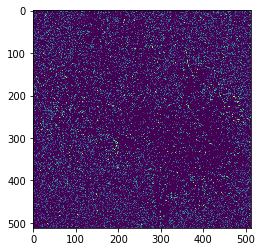

In [229]:
plt.imshow(subtracted_filtered[379])

In [243]:
f = tp.locate(subtracted_filtered[379],25,minmass=8000)

(array([14.,  4.,  4.,  8.,  2.,  2.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 8026.55910831,  9444.22634526, 10861.89358221, 12279.56081915,
        13697.2280561 , 15114.89529305, 16532.56253   , 17950.22976694,
        19367.89700389, 20785.56424084, 22203.23147778, 23620.89871473,
        25038.56595168, 26456.23318863, 27873.90042557, 29291.56766252,
        30709.23489947, 32126.90213641, 33544.56937336, 34962.23661031,
        36379.90384726]),
 <a list of 20 Patch objects>)

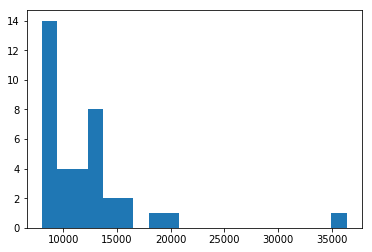

In [244]:
plt.hist(f['mass'],bins=20)

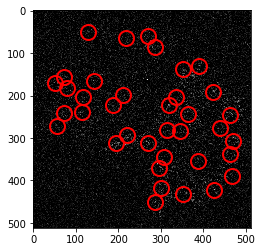

In [245]:
plt.figure()
tp.annotate(f,filtered_bright_stack[379])

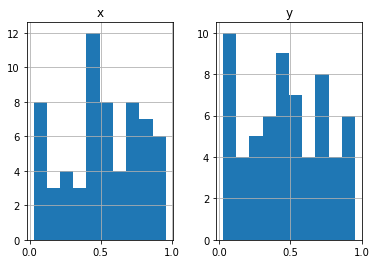

In [90]:
tp.subpx_bias(f)
plt.show()

In [91]:
f = tp.batch(filtered_bright_stack, 25, minmass=10000)

Frame 599: 59 features


In [92]:
t = tp.link_df(f,5,memory=1)

Frame 599: 59 trajectories present.


In [93]:
t1 = tp.filter_stubs(t,3)

In [94]:
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 14828
After: 3514


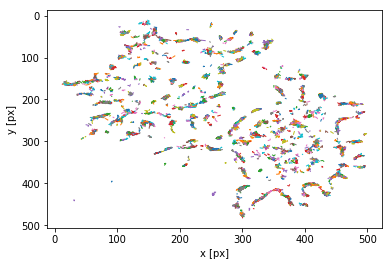

In [96]:
plt.figure()
tp.plot_traj(t1)

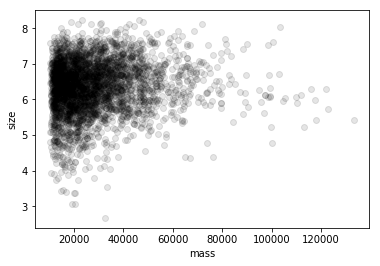

In [101]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass